### Chicago Trends Uncovered Using Python

# Scenario

For this project, I work as a data analyst to uncover trends from various datasets.The dataset used for this project were gotten from the chicago data portal:  https://data.cityofchicago.org/.
The City of Chicago's open data portal lets you find city data, lets you find facts about your neighborhood, lets you create maps and graphs about the city, and lets you freely download the data for your own analysis. Many of these datasets are updated at least once a day, and many of them are updated several times a day.

# Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats 
import requests
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")
from ipywidgets import interact,interactive,fixed,interact_manual
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import os
warnings.filterwarnings("ignore", category=FutureWarning)


# Importing Datasets

In [2]:
census_df =  pd.read_csv("../input/chicago-data/ChicagoCensusData.csv")
crime_df =  pd.read_csv("../input/chicago-data/ChicagoCrimeData.csv")
schools_df =  pd.read_csv("../input/chicago-data/Chicago_Public_Schools_-_Progress_Report_Cards__2011-2012__20240725.csv")                               
                               

# Objective

In this project, I will be working with Python and SQLite to demonstrate how I handle Databases with the combination of python and SQL. My aim is to uncover trends from the 3 datasets. 

# Data Wrangling

In [3]:
# Handling missing values
schools_df.dropna(inplace=True)
census_df.dropna(inplace=True)
crime_df.dropna(inplace=True)

# Converting columns to appropriate data types if necessary
crime_df['DATE'] = pd.to_datetime(crime_df['DATE'])

# Storing Data in SQLite

In [4]:
import csv, sqlite3

In [5]:
# Creating SQLite connection
conn = sqlite3.connect("chicago_data.db")
cur = conn.cursor()

# Storing dataframes in SQLite
schools_df.to_sql('ChicagoPublicSchools', conn, if_exists='replace', index=False)
census_df.to_sql('ChicagoCensusData', conn, if_exists='replace', index=False)
crime_df.to_sql('ChicagoCrimeData', conn, if_exists='replace', index=False)

487

# Exploratory Data Analysis (EDA)

in the cource of this section, I will perform the following tasks:

* Perfrom intensive exploratory analysis on each dataset by using various data visualization techniques and SQL quries. 
* Create and analyze various **VIEWS** USING SQlite and line magic commands.

# 1. Analysis Of Census Data

In [6]:
census_df.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16__UNEMPLOYED,PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


To get an understanding of the distribution of each feauture of the dataset,I created histograms for each variable.

<h2>Distribution of Each Indicator<h2>

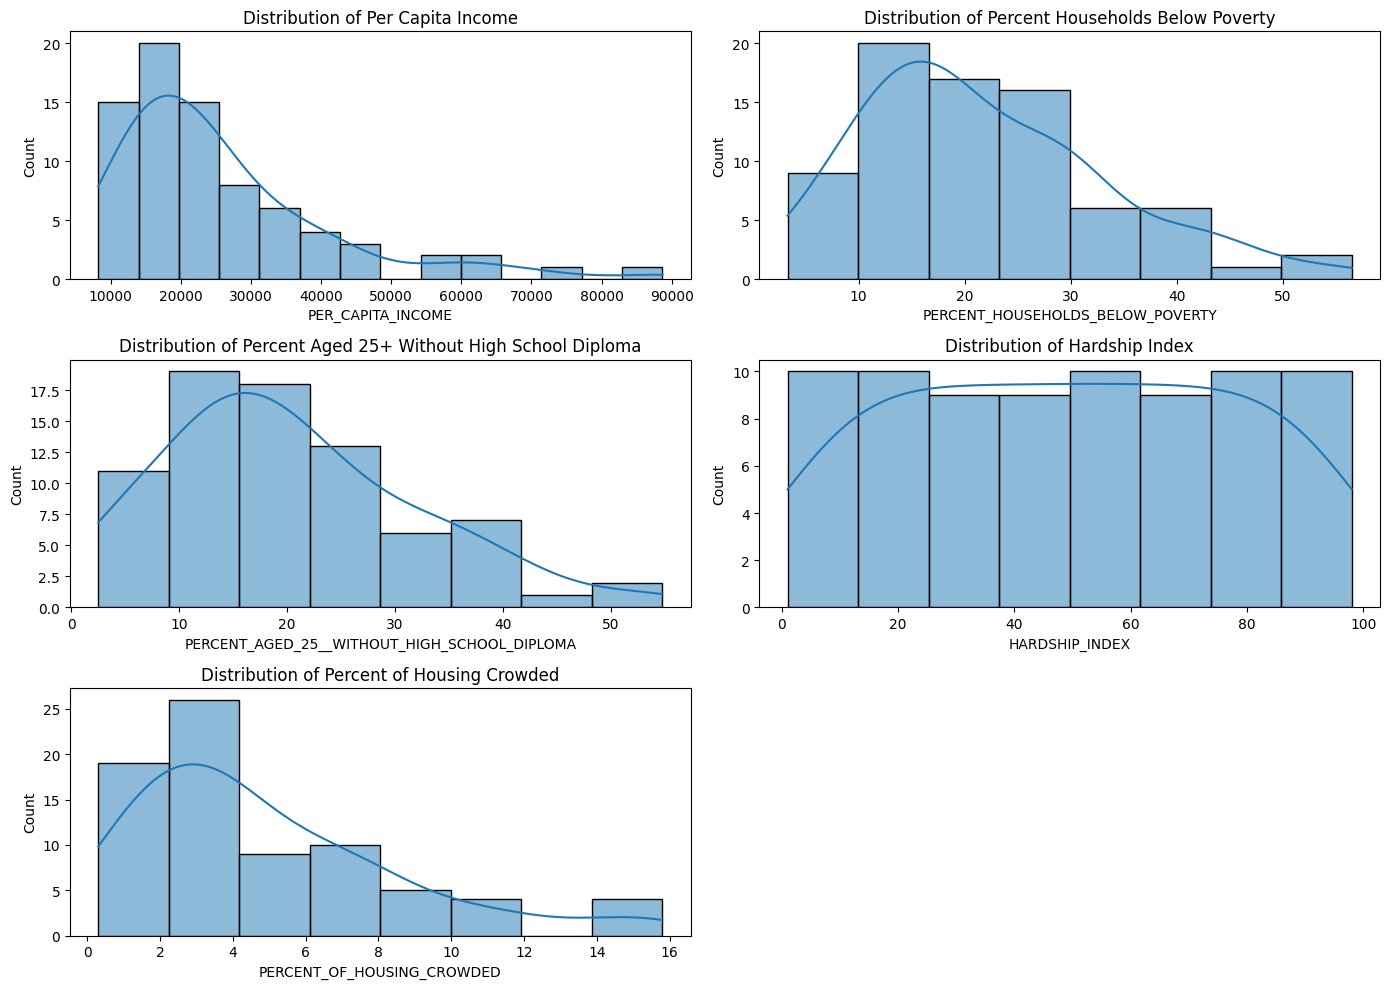

In [7]:
# Creating subplots with only the required number of plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axes = axes.flatten()

# Listing of columns to plot
columns_to_plot = [
    'PER_CAPITA_INCOME',
    'PERCENT_HOUSEHOLDS_BELOW_POVERTY',
    'PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA',
    'HARDSHIP_INDEX',
    'PERCENT_OF_HOUSING_CROWDED'
]

# Titles for the plots
titles = [
    'Distribution of Per Capita Income',
    'Distribution of Percent Households Below Poverty',
    'Distribution of Percent Aged 25+ Without High School Diploma',
    'Distribution of Hardship Index',
    'Distribution of Percent of Housing Crowded'
]

# Plotting each column
for i, col in enumerate(columns_to_plot):
    sns.histplot(census_df[col], kde=True, ax=axes[i])
    axes[i].set_title(titles[i])

# Removing any unused subplots
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<h2>Correlation Heatmap<h2>

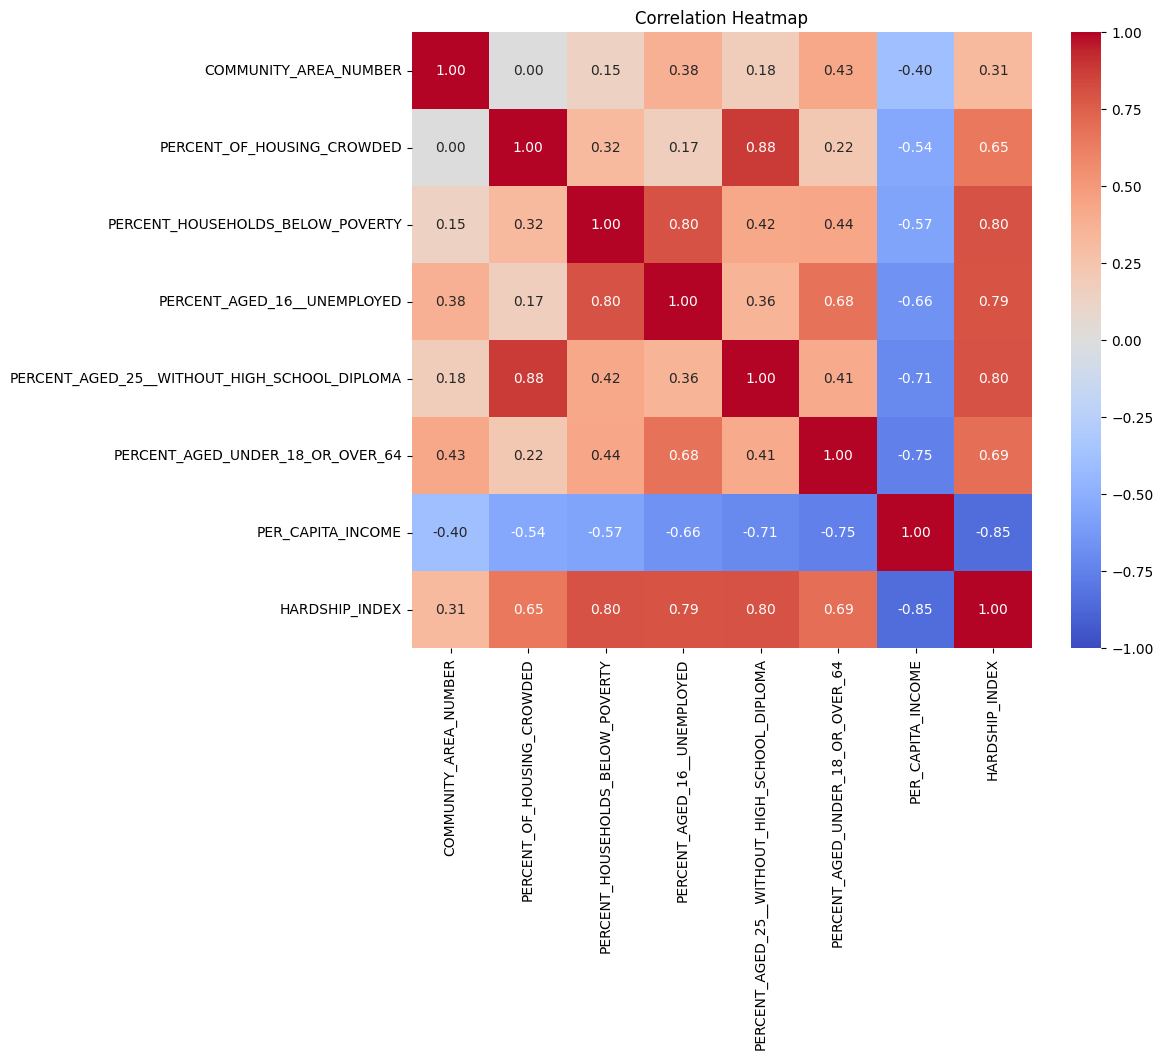

In [8]:
# Selecting only numeric columns
census_df = census_df.select_dtypes(include=[np.number])

# Checking for non-numeric values in numeric_df
non_numeric_columns = census_df.columns[census_df.dtypes == object]
if not non_numeric_columns.empty:
    print(f"Warning: Non-numeric columns found: {', '.join(non_numeric_columns)}")

# Converting numeric columns to float (handling any conversion issues)
numeric_df = census_df.apply(pd.to_numeric, errors='coerce')

# Computing the correlation matrix
corr = numeric_df.corr()

# Creating a heatmap
plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0)
plt.show()

 Next, i will perform EDA on various correlative features with a line magic command and seaborn library:

In [9]:
%load_ext sql

<h2> 1. Plotting the percentage of crowded houses VS Age 25 without school diploma<h2>

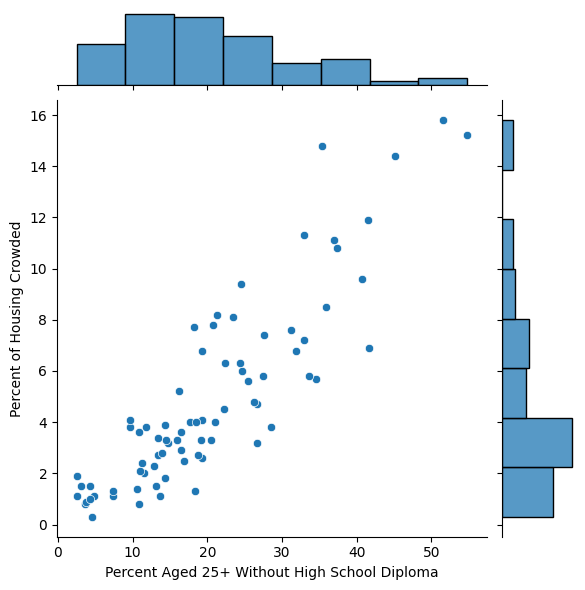

In [10]:
conn = sqlite3.connect("chicago_data.db")
cur = conn.cursor()


# Runing the SQL query
query = """
SELECT PERCENT_OF_HOUSING_CROWDED, PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA
FROM ChicagoCensusData;
"""
crowded_houses_vs_without_diploma = pd.read_sql_query(query, conn)

# Closing the connection
conn.close()

# Plotting using Seaborn
plot = sns.jointplot(
    x='PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA',
    y='PERCENT_OF_HOUSING_CROWDED',
    data=crowded_houses_vs_without_diploma,
    kind='scatter'
)

plot.set_axis_labels('Percent Aged 25+ Without High School Diploma', 'Percent of Housing Crowded')
plt.show()

**Interpretation:**

1. Positive Correlation:
* The plot shows a clear positive  correlation between 'percentage of people age 25 and above without school diploma  ' (x-axis) and 'percentage of crowded houses' (y-axis). As the  percentage of people without diploma  increases, the percentage of crowded houses tends to increase . This suggests that lower educational attainment is associated with lower rate of crowded houses.
2. Density of Points:
* The density of points is higher in the lower left corner, indicating that most data points have lower percentages of both variables. This means that in many regions, both the percentage of people without a high school diploma and the percentage of crowded houses  are relatively low..

3. Outliers:
* There are some outliers, especially in the upper right part of the plot, where regions have both high percentages of people without a high school diploma and high percentages of crowded houses.

4. Marginal Histograms:
* The histograms on the top and right sides of the plot show the distributions of each variable individually. The distribution of the percentage of people  aged 25 without high school diploma is skewed towards the lower end, with most regions having a lower percentage of people without a high school diploma..
* The histogram on the right shows the distribution of crowded houses, which is skewed towards lower values. Most regions have  low percentage of crowded houses  .

**Conclusion:** The scatter plot with marginal histograms clearly demonstrates a strong positive relationship between people without school diploma and crowded houses. Areas with higher percentages of people without a high school diploma tend to have higher percentages of crowded houses . This visualization helps to emphasize the importance of education in reducing levels of crowded houses. In other words "Go to school , get a job, save and rent a house ".

<h2> 2. Plotting the percentage below poverty VS hardship index<h2>

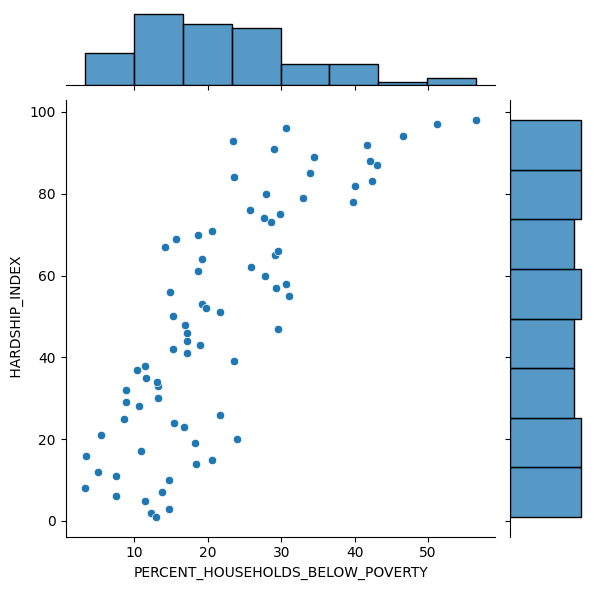

In [11]:
conn = sqlite3.connect("chicago_data.db")
cur = conn.cursor()


# Runing the SQL query
query = """
SELECT PERCENT_HOUSEHOLDS_BELOW_POVERTY, HARDSHIP_INDEX
FROM ChicagoCensusData;
"""
BELOW_POVERTY_vs_HARDSHIP_INDEX = pd.read_sql_query(query, conn)

# Closing the connection
conn.close()

# Plotting using Seaborn
plot = sns.jointplot(
    x='PERCENT_HOUSEHOLDS_BELOW_POVERTY',
    y='HARDSHIP_INDEX',
    data=BELOW_POVERTY_vs_HARDSHIP_INDEX,
    kind='scatter'
)

plot.set_axis_labels('PERCENT_HOUSEHOLDS_BELOW_POVERTY', ' HARDSHIP_INDEX')
plt.show()

**Interpretation:**

1. Positive Correlation:
* The plot demonstrates a positive correlation between the two variables. As the percentage of households below poverty  increases, the hardship index also tends to increase. This indicates that higher rate of households living below poverty are associated with an higher hardship index.
2. Density of Points:
* The density of points is higher in the lower left corner, indicating that most data points have lower percentages of both variables. This means that in many regions, both the percentage of people living below poverty line and the hardship index are relatively low.

3. Outliers:
* There are some outliers, especially in the upper right part of the plot, where regions have both high percentages of people living below poverty line and hardship index.

4. Marginal Histograms:
* The distribution of the percentage of households ling below poverty also appears to be skewed towards the lower end, with most regions having a lower percentage of households below the poverty line.
* The histogram on the right shows the distribution of hardship_index, which is skewed towards higher values. Most regions have a higher hardship index.

**Conclusion:** The scatter plot with marginal histograms clearly demonstrates a strong positive relationship between the percentage of people living below poverty line and hardship index. Areas with higher percentages of people living below poverty line tend to have an higher hardship index. This visualization helps to emphasize the importance of money in reducing the level of hardship .

 Further analysis on the hardship index:

In [12]:
conn = sqlite3.connect("chicago_data.db")
cur = conn.cursor()
%sql sqlite:///chicago_data.db

* To find the average hardship index:

In [13]:
%%sql
SELECT AVG(HARDSHIP_INDEX)
FROM ChicagoCensusData;

 * sqlite:///chicago_data.db
Done.


AVG(HARDSHIP_INDEX)
49.506493506493506


* To find the highest hardship index:

In [14]:
%%sql
SELECT  MAX(HARDSHIP_INDEX)
FROM ChicagoCensusData;

 * sqlite:///chicago_data.db
Done.


MAX(HARDSHIP_INDEX)
98.0


* To find the lowest hardship index:

In [15]:
%%sql
SELECT COMMUNITY_AREA_NAME, MIN(HARDSHIP_INDEX)
FROM ChicagoCensusData;

 * sqlite:///chicago_data.db
Done.


COMMUNITY_AREA_NAME,MIN(HARDSHIP_INDEX)
Near North Side,1.0


<h2> 3. percentage of unemployed people above age 16 VS hardship index<h2>

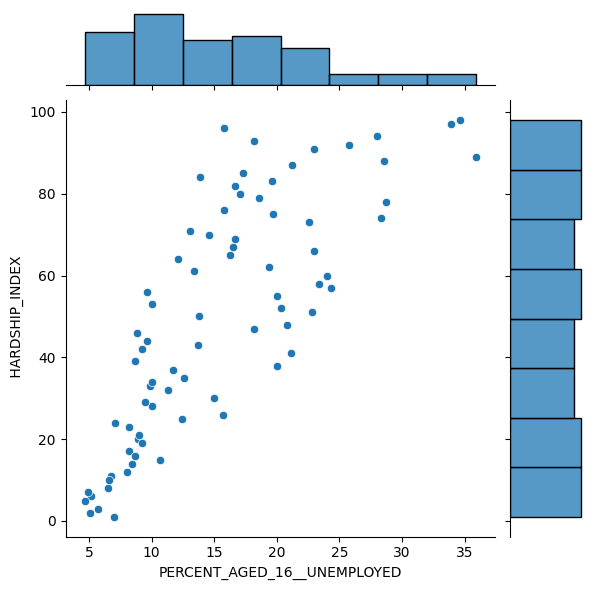

In [16]:
conn = sqlite3.connect("chicago_data.db")
cur = conn.cursor()


# Runing the SQL query
query = """
SELECT PERCENT_AGED_16__UNEMPLOYED, HARDSHIP_INDEX
FROM ChicagoCensusData;
"""
unemployed_16_vs_HARDSHIP_INDEX = pd.read_sql_query(query, conn)

# Closing the connection
conn.close()

# Plotting using Seaborn
plot = sns.jointplot(
    x='PERCENT_AGED_16__UNEMPLOYED',
    y='HARDSHIP_INDEX',
    data=unemployed_16_vs_HARDSHIP_INDEX,
    kind='scatter'
)

plot.set_axis_labels('PERCENT_AGED_16__UNEMPLOYED', ' HARDSHIP_INDEX')
plt.show()

**Interpretation:**

1. Positive Correlation:
* The plot demonstrates a strong positive correlation between the two variables. As the percentage of unemployed people above the age of 16  increases, the hardship index also tends to increase. This indicates that higher rate of unemployment is associated with an higher hardship index.
2. Density of Points:
* The density of points is higher in the lower left corner, indicating that most data points have lower percentages of both variables. This means that in many regions, both the percentage of unemployed people above the age of 16 and the hardship index are relatively low.

3. Outliers:
* There are some outliers, especially in the upper right part of the plot, where regions have both high percentages of unemployed people above the age of 16 and hardship index.

4. Marginal Histograms:
* The distribution of the percentage of unemployed people above the age of 16 also appears to be skewed towards the lower end, with most regions having a lower percentage of unemployed people above the age of 16.
* The histogram on the right shows the distribution of hardship_index, which is skewed towards higher values. Most regions have a higher hardship index.

**Conclusion:** The scatter plot with marginal histograms clearly demonstrates a strong positive relationship between the percentage of unemployed people above the age of 16 and hardship index. Areas with higher percentages of unemployed people above the age of 16 tend to have an higher hardship index. This visualization helps to emphasize the importance of employment in reducing the level of hardship .

<h2> 4. plotting the percentage of individuals aged 25 without diploma VS per capital income<h2>

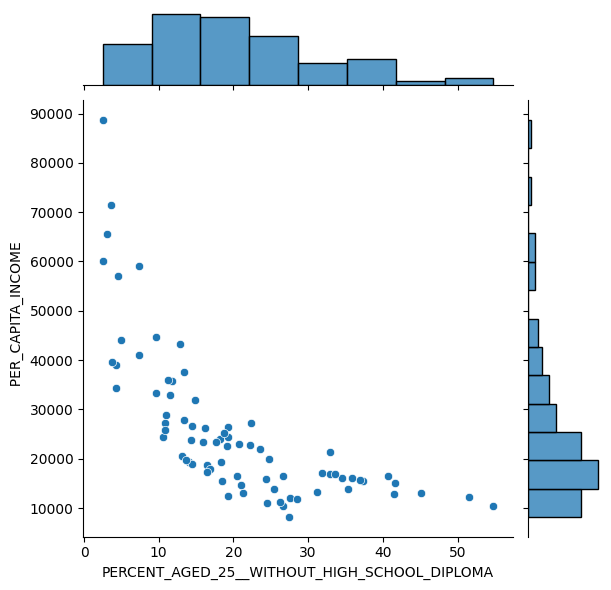

In [17]:
conn = sqlite3.connect("chicago_data.db")
cur = conn.cursor()

# Runing the SQL query
query = """
SELECT PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA, PER_CAPITA_INCOME
FROM ChicagoCensusData;
"""
without_diploma_vs_per_capital_income = pd.read_sql_query(query, conn)

# Closing the connection
conn.close()

# Plotting using Seaborn
plot = sns.jointplot(
    x='PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA',
    y='PER_CAPITA_INCOME',
    data=without_diploma_vs_per_capital_income,
    kind='scatter'
)

plot.set_axis_labels('PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA', '  PER_CAPITA_INCOME')
plt.show()

**Interpretation:**
 
1. Negative Correlation:
* The plot shows a clear negative correlation between the  'percentage of people age 25 and above without school diploma ' (x-axis) and 'percentage of capital income ' (y-axis). As the percentage of people age 25 and above without school diploma increases, the per capita income tends to decrease. This indicates that higher levels of people age 25 and above without school diploma are associated with lower levels of capital income.

2. Density of Points:
* The density of points is higher on the left side of the plot, where the per capita income is lower, and the percentage of people age 25 and above without school diplomais higher. This suggests that many regions have low income and low percentage of people age 25 and above without school diploma.

3. Outliers:
* There are a few points towards the right side of the plot where the percentage of people age 25 and above without school diploma is significantly higher, but the capital income is very low. These points indicate regions with low income and high percentage of people age 25 and above without school diploma.

4. Marginal Histograms:
* The histograms on the top and right sides of the plot show the distributions of each variable individually. The distribution of the percentage of people aged 25 without high school diploma is skewed towards the lower end, with most regions having a lower percentage of people without a high school diploma..
* The histogram on the right shows the distribution of the percentage of capital income, which is skewed towards lower income values. Most regions have a lower per capita income.

**Conclusion:** The scatter plot with marginal histograms clearly demonstrates a strong negative relationship between people without school diploma and capital income. Regions with higher percentage of people age 25 and above without school diploma experience lower levels of capital income. This visualization emphasizes the importance of acquring a school diploma to increase capital incomein various regions.


<h2> 5. Plotting The Income per capita vs Hardship index<h2>

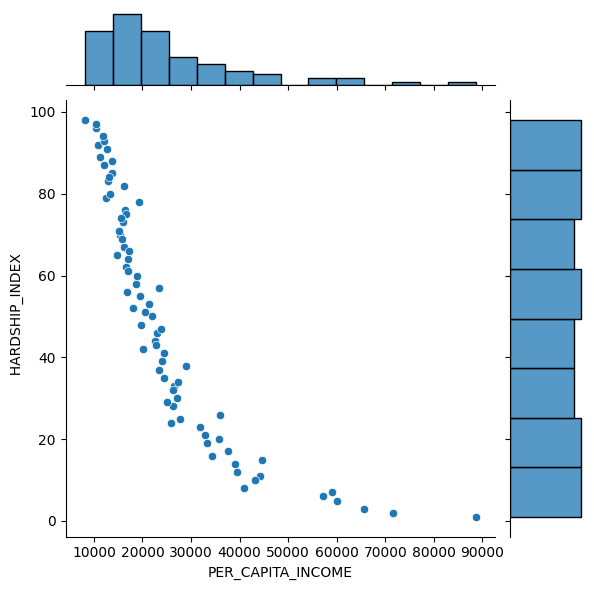

In [18]:
conn = sqlite3.connect("chicago_data.db")
cur = conn.cursor()

# Runing the SQL query
query = """
SELECT PER_CAPITA_INCOME, HARDSHIP_INDEX
FROM ChicagoCensusData;
"""
per_capital_incomevs_hardship_index = pd.read_sql_query(query, conn)

# Closing the connection
conn.close()

# Plotting using Seaborn
plot = sns.jointplot(
    x='PER_CAPITA_INCOME',
    y='HARDSHIP_INDEX',
    data=per_capital_incomevs_hardship_index,
    kind='scatter'
)

plot.set_axis_labels('PER_CAPITA_INCOME', '  HARDSHIP_INDEX')
plt.show()

**Interpretation:**

1. Negative Correlation:
* The plot shows a clear negative correlation between 'per_capitaincome' (x-axis) and 'hardship_index' (y-axis). As the per capita income increases, the hardship index tends to decrease. This indicates that higher income levels are associated with lower levels of hardship.

2. Density of Points:
* The density of points is higher on the left side of the plot, where the per capita income is lower, and the hardship index is higher. This suggests that many regions have low income and high hardship levels.

3. Outliers:
* There are a few points towards the right side of the plot where the per capita income is significantly higher, but the hardship index is very low. These points indicate regions with high income and low hardship.

4. Marginal Histograms:
* The histogram on the top shows the distribution of the percentage of capital income, which is skewed towards lower income values. Most regions have a lower per capita income.
* The histogram on the right shows the distribution of hardship_index, which is skewed towards higher values. Most regions have a higher hardship index.

**Conclusion:** The scatter plot with marginal histograms clearly demonstrates a strong negative relationship between income and hardship. Regions with higher per capita income experience lower levels of hardship, highlighting the impact of economic well-being on overall hardship levels. This visualization emphasizes the importance of increasing income levels to reduce hardship in various regions.

<h2> 6. Plotting The Income per capital vs Percentage of Households below poverty line<h2>

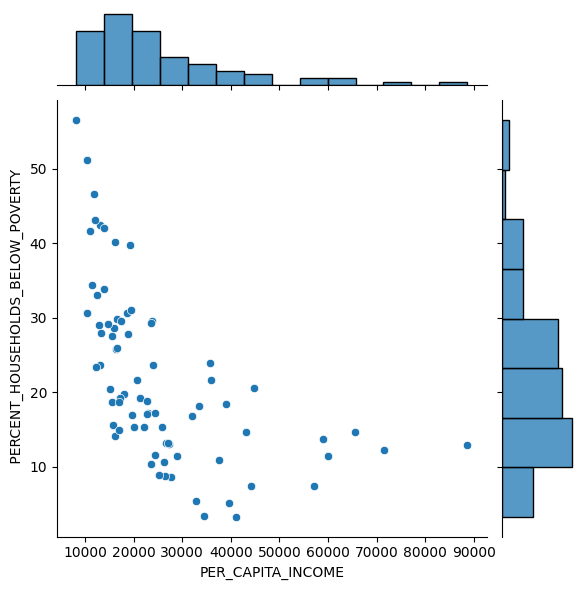

In [19]:
conn = sqlite3.connect("chicago_data.db")
cur = conn.cursor()

# Runing the SQL query
query = """
SELECT PER_CAPITA_INCOME,PERCENT_HOUSEHOLDS_BELOW_POVERTY
FROM ChicagoCensusData;
"""
per_capital_incomevs_PERCENT_HOUSEHOLDS_BELOW_POVERTY = pd.read_sql_query(query, conn)

# Closing the connection
conn.close()

# Plotting using Seaborn
plot = sns.jointplot(
    x='PER_CAPITA_INCOME',
    y='PERCENT_HOUSEHOLDS_BELOW_POVERTY',
    data=per_capital_incomevs_PERCENT_HOUSEHOLDS_BELOW_POVERTY,
    kind='scatter'
)

plot.set_axis_labels('PER_CAPITA_INCOME', ' PERCENT_HOUSEHOLDS_BELOW_POVERTY')
plt.show()

**Interpretation:**

1. Negative Correlation:
* The plot shows a clear negative correlation between 'per_capitaincome' (x-axis) and 'percent_households_below_poverty' (y-axis). As the per capita income increases, the percentage of households below the poverty line tends to decrease. This suggests that higher income levels are associated with lower poverty rates.

2. Density of Points:
* The density of points is higher on the left side of the plot, where the per capita income is lower, and the percentage of households below poverty is higher. This indicates that many regions have low income and high poverty rates. 

3. Outliers:
* There are a few points towards the right side of the plot where the per capita income is significantly higher, but the percentage of households below poverty is very low. These points indicate regions with high income and low poverty rates.

4. Marginal Histograms:
* The histogram on the top shows the distribution of per_capitaincome, which is skewed towards lower income values. Most regions have a lower per capita income.
* The histogram on the right shows the distribution of percent_households_below_poverty, which is skewed towards higher values. Most regions have a higher percentage of households below the poverty line.

**Conclusion:** The scatter plot with marginal histograms clearly demonstrates a strong negative relationship between per capita income and the percentage of households below the poverty line. Regions with higher per capita income experience lower levels of poverty, highlighting the impact of economic well-being on poverty levels. This visualization emphasizes the importance of increasing income levels to reduce poverty in various regions.

## EDA Using SQL  Queries

In [20]:
conn = sqlite3.connect("chicago_data.db")
cur = conn.cursor()
%sql sqlite:///chicago_data.db

1. How many community areas in Chicago have a hardship index greater than 50.0?

In [21]:
%%sql
SELECT  COUNT(*)
FROM ChicagoCensusData
WHERE HARDSHIP_INDEX> 50.0;

 * sqlite:///chicago_data.db
Done.


COUNT(*)
38


2. Which community area which has the highest hardship index?

In [22]:
%%sql
SELECT COMMUNITY_AREA_NAME, MAX(HARDSHIP_INDEX)
FROM ChicagoCensusData;

 * sqlite:///chicago_data.db
Done.


COMMUNITY_AREA_NAME,MAX(HARDSHIP_INDEX)
Riverdale,98.0


3. Which Chicago community areas have per-capita incomes greater than $60,000?

In [23]:
%%sql
SELECT COMMUNITY_AREA_NAME
FROM ChicagoCensusData
WHERE PER_CAPITA_INCOME > 60000;

 * sqlite:///chicago_data.db
Done.


COMMUNITY_AREA_NAME
Lake View
Lincoln Park
Near North Side
Loop


4. Which community area has the highest percentage of crowded houses?

In [24]:
%%sql
SELECT COMMUNITY_AREA_NAME, MAX(PERCENT_OF_HOUSING_CROWDED) AS max_crowded_house
FROM ChicagoCensusData

 * sqlite:///chicago_data.db
Done.


COMMUNITY_AREA_NAME,max_crowded_house
Gage Park,15.8


5. Which community area has the lowest percentage of crowded houses?

In [25]:
%%sql
SELECT COMMUNITY_AREA_NAME, MIN(PERCENT_OF_HOUSING_CROWDED) AS min_crowded_house
FROM ChicagoCensusData

 * sqlite:///chicago_data.db
Done.


COMMUNITY_AREA_NAME,min_crowded_house
North Center,0.3


# 2. Analysis OF The Chicago Crime Data

In [26]:
crime_df.head()

,ID,CASE_NUMBER,DATE,BLOCK,IUCR,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,ARREST,DOMESTIC,...,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,FBICODE,X_COORDINATE,Y_COORDINATE,YEAR,LATITUDE,LONGITUDE,LOCATION
0,3512276,HK587712,2004-08-28,047XX S KEDZIE AVE,890,THEFT,FROM BUILDING,SMALL RETAIL STORE,False,False,...,9,14.0,58.0,6,1155838.0,1873050.0,2004,41.807440,-87.703956,"(41.8074405, -87.703955849)"
1,3406613,HK456306,2004-06-26,009XX N CENTRAL PARK AVE,820,THEFT,$500 AND UNDER,OTHER,False,False,...,11,27.0,23.0,6,1152206.0,1906127.0,2004,41.898280,-87.716406,"(41.898279962, -87.716405505)"
2,8002131,HT233595,2011-04-04,043XX S WABASH AVE,820,THEFT,$500 AND UNDER,NURSING HOME/RETIREMENT HOME,False,False,...,2,3.0,38.0,6,1177436.0,1876313.0,2011,41.815933,-87.624642,"(41.815933131, -87.624642127)"
3,7903289,HT133522,2010-12-30,083XX S KINGSTON AVE,840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,...,4,7.0,46.0,6,1194622.0,1850125.0,2010,41.743665,-87.562463,"(41.743665322, -87.562462756)"
4,10402076,HZ138551,2016-02-02,033XX W 66TH ST,820,THEFT,$500 AND UNDER,ALLEY,False,False,...,8,15.0,66.0,6,1155240.0,1860661.0,2016,41.773455,-87.706480,"(41.773455295, -87.706480471)"


<h2>Distribution of Each Indicator<h2>



To get an understanding of the distribution of each feauture of the dataset,I created histograms for each variable.

In [27]:
# Convert boolean column to integer
crime_df['ARREST'] = crime_df['ARREST'].astype(int)

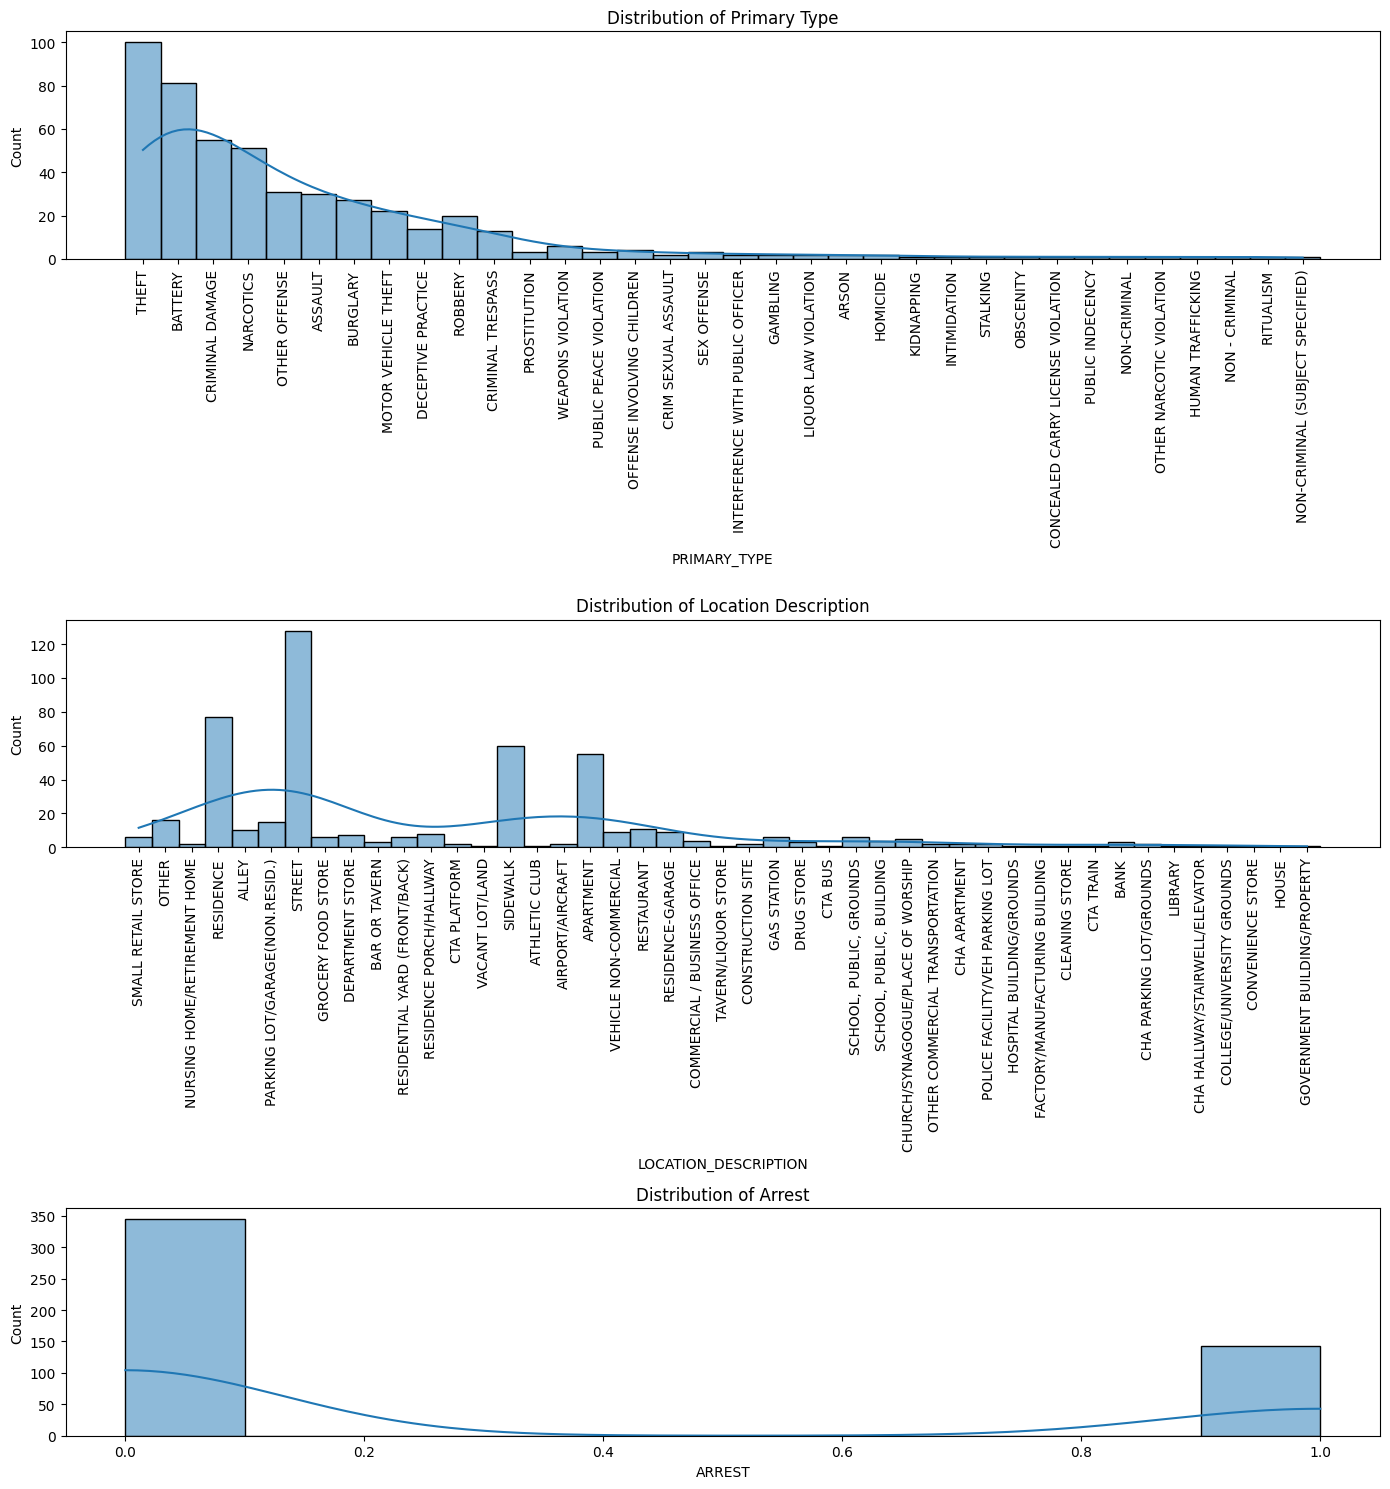

In [28]:
# Distribution plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 15))

# Plot for PRIMARY_TYPE
sns.histplot(crime_df['PRIMARY_TYPE'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Primary Type')
axes[0].tick_params(axis='x', rotation=90)

# Plot for LOCATION_DESCRIPTION
sns.histplot(crime_df['LOCATION_DESCRIPTION'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Location Description')
axes[1].tick_params(axis='x', rotation=90)

# Plot for ARREST
sns.histplot(crime_df['ARREST'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Arrest')

plt.tight_layout()
plt.show()

# 

## EDA Using SQL Queries

1. Number of crimes per year

In [29]:
query = """
SELECT strftime('%Y', DATE) AS Year, COUNT(*) AS CrimeCount
FROM ChicagoCrimeData
GROUP BY Year
ORDER BY Year;
"""
crime_counts = pd.read_sql(query, conn)
print(crime_counts)

    Year  CrimeCount
0   2001           1
1   2002          29
2   2003          42
3   2004          33
4   2005          44
5   2006          29
6   2007          36
7   2008          20
8   2009          43
9   2010          25
10  2011          25
11  2012          30
12  2013          24
13  2014          24
14  2015          23
15  2016          26
16  2017          30
17  2018           3


* Visualizing the crime counts per year:

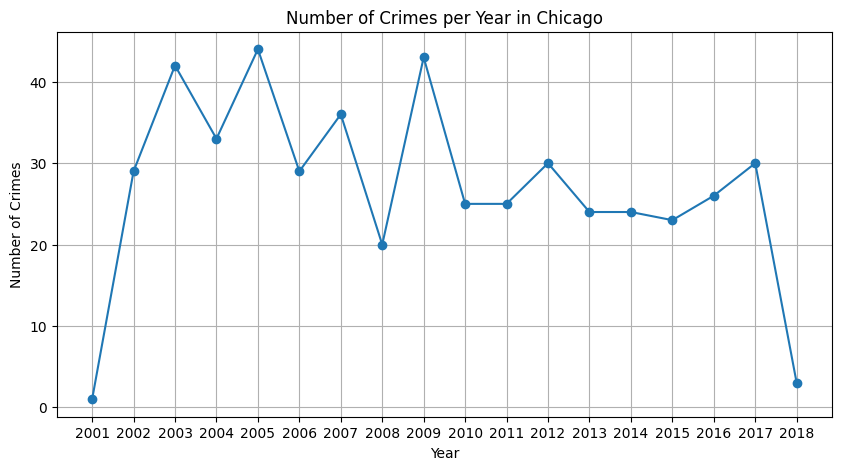

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(crime_counts['Year'], crime_counts['CrimeCount'], marker='o')
plt.title('Number of Crimes per Year in Chicago')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.show()

2. Identifying all kidnapping crimes involving a child

In [31]:
%sql SELECT *\
FROM ChicagoCrimeData\
WHERE PRIMARY_TYPE = 'KIDNAPPING'\
AND (DESCRIPTION LIKE '%CHILD%' \
     OR DESCRIPTION LIKE '%CHILDREN%'\
     OR DESCRIPTION LIKE '%MINOR%'\
     OR DESCRIPTION LIKE '%INFANT%'\
     OR DESCRIPTION LIKE '%JUVENILE%');

 * sqlite:///chicago_data.db
Done.


ID,CASE_NUMBER,DATE,BLOCK,IUCR,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,ARREST,DOMESTIC,BEAT,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,FBICODE,X_COORDINATE,Y_COORDINATE,YEAR,LATITUDE,LONGITUDE,LOCATION
5276766,HN144152,2007-01-26 00:00:00,050XX W VAN BUREN ST,1792,KIDNAPPING,CHILD ABDUCTION/STRANGER,STREET,0,0,1533,15,29.0,25.0,20,1143050.0,1897546.0,2007,41.87490841,-87.75024931,"(41.874908413, -87.750249307)"


3. Listing all case numbers, location description for crimes involving minors?(children are not considered minors for the purposes of crime analysis)

In [32]:
%%sql
SELECT CASE_NUMBER, LOCATION_DESCRIPTION
FROM ChicagoCrimeData
WHERE DESCRIPTION LIKE '%MINOR%'
       OR DESCRIPTION LIKE '%JUVENILE%' 
       OR DESCRIPTION LIKE '%INFANT%'
       AND DESCRIPTION NOT LIKE '%CHILD%' 
       AND DESCRIPTION NOT LIKE '%CHILDREN%';


 * sqlite:///chicago_data.db
Done.


CASE_NUMBER,LOCATION_DESCRIPTION
HL266884,CONVENIENCE STORE
HK238408,ALLEY


4.  Crimes that were recorded at schools.

In [33]:
%%sql
SELECT *
FROM ChicagoCrimeData
WHERE LOCATION_DESCRIPTION LIKE '%SCHOOL%';

 * sqlite:///chicago_data.db
Done.


ID,CASE_NUMBER,DATE,BLOCK,IUCR,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,ARREST,DOMESTIC,BEAT,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,FBICODE,X_COORDINATE,Y_COORDINATE,YEAR,LATITUDE,LONGITUDE,LOCATION
4006321,HL353697,2005-05-04 00:00:00,077XX S BURNHAM AVE,460,BATTERY,SIMPLE,"SCHOOL, PUBLIC, GROUNDS",0,0,421,4,7.0,43.0,08B,1196066.0,1854156.0,2005,41.75469107,-87.55703869,"(41.754691074, -87.557038686)"
4430638,HL725506,2005-11-09 00:00:00,048XX N FRANCISCO AVE,484,BATTERY,PRO EMP HANDS NO/MIN INJURY,"SCHOOL, PUBLIC, BUILDING",1,0,2031,20,40.0,4.0,08B,1156348.0,1932071.0,2005,41.96938944,-87.70048881,"(41.96938944, -87.700488807)"
6644618,HP716225,2008-12-04 00:00:00,030XX S DR MARTIN LUTHER KING JR DR,460,BATTERY,SIMPLE,"SCHOOL, PUBLIC, BUILDING",0,0,2112,1,2.0,35.0,08B,1179306.0,1885032.0,2008,41.83981621,-87.61751617,"(41.839816207, -87.617516172)"
2341955,HH639427,2002-09-10 00:00:00,005XX N WALLER AVE,460,BATTERY,SIMPLE,"SCHOOL, PUBLIC, BUILDING",0,0,1512,15,29.0,25.0,08B,1138238.0,1903181.0,2002,41.89045993,-87.76778089,"(41.890459933, -87.767780886)"
11110571,JA460432,2017-10-05 00:00:00,076XX S HOMAN AVE,460,BATTERY,SIMPLE,"SCHOOL, PUBLIC, GROUNDS",0,0,835,8,18.0,70.0,08B,1155024.0,1853614.0,2017,41.75412154,-87.70746025,"(41.754121535, -87.707460248)"
7399281,HS200939,2010-03-10 00:00:00,053XX W CONGRESS PKWY,1320,CRIMINAL DAMAGE,TO VEHICLE,"SCHOOL, PUBLIC, GROUNDS",0,0,1522,15,29.0,25.0,14,1140822.0,1897164.0,2010,41.8739014,-87.7584391,"(41.873901397, -87.758439102)"
3530721,HK577020,2004-08-23 00:00:00,016XX W JONQUIL TER,2024,NARCOTICS,POSS: HEROIN(WHITE),"SCHOOL, PUBLIC, GROUNDS",1,0,2422,24,49.0,1.0,18,1163893.0,1951001.0,2004,42.0211776,-87.67220843,"(42.021177601, -87.67220843)"
7502426,HS305355,2010-05-13 00:00:00,035XX S WASHTENAW AVE,1821,NARCOTICS,MANU/DEL:CANNABIS 10GM OR LESS,"SCHOOL, PUBLIC, BUILDING",1,0,913,9,12.0,58.0,18,1158944.0,1880896.0,2010,41.82890791,-87.69234919,"(41.828907913, -87.692349187)"
8082600,HT315369,2011-05-26 00:00:00,032XX W ADAMS ST,545,ASSAULT,PRO EMP HANDS NO/MIN INJURY,"SCHOOL, PUBLIC, GROUNDS",0,0,1124,11,28.0,27.0,08A,1154752.0,1898890.0,2011,41.87837031,-87.70724814,"(41.878370307, -87.707248137)"
7174283,HR585012,2009-10-13 00:00:00,043XX W 79TH ST,1330,CRIMINAL TRESPASS,TO LAND,"SCHOOL, PUBLIC, GROUNDS",1,0,834,8,13.0,70.0,26,1148764.0,1851854.0,2009,41.74941446,-87.7304466,"(41.749414464, -87.730446597)"


5. Using a sub-query to determine the Community Area Name with most number of crimes?

In [34]:
%%sql
SELECT ca.COMMUNITY_AREA_NAME
FROM ChicagoCrimeData ccd
JOIN ChicagoCensusData ca
ON ccd.COMMUNITY_AREA_NUMBER = ca.COMMUNITY_AREA_NUMBER
GROUP BY ca.COMMUNITY_AREA_NAME
ORDER BY COUNT(ccd.ID) DESC
LIMIT 1;



 * sqlite:///chicago_data.db
Done.


COMMUNITY_AREA_NAME
Austin


6. Top 10 crime counts per primary type

In [35]:
query = """
SELECT PRIMARY_TYPE, COUNT(*) AS CrimeCount
FROM ChicagoCrimeData
GROUP BY PRIMARY_TYPE
ORDER BY CrimeCount DESC
LIMIT 10;
"""
crime_type_counts = pd.read_sql(query, conn)
print(crime_type_counts)

          PRIMARY_TYPE  CrimeCount
0                THEFT         100
1              BATTERY          81
2      CRIMINAL DAMAGE          55
3            NARCOTICS          51
4        OTHER OFFENSE          31
5              ASSAULT          30
6             BURGLARY          27
7  MOTOR VEHICLE THEFT          22
8              ROBBERY          20
9   DECEPTIVE PRACTICE          14


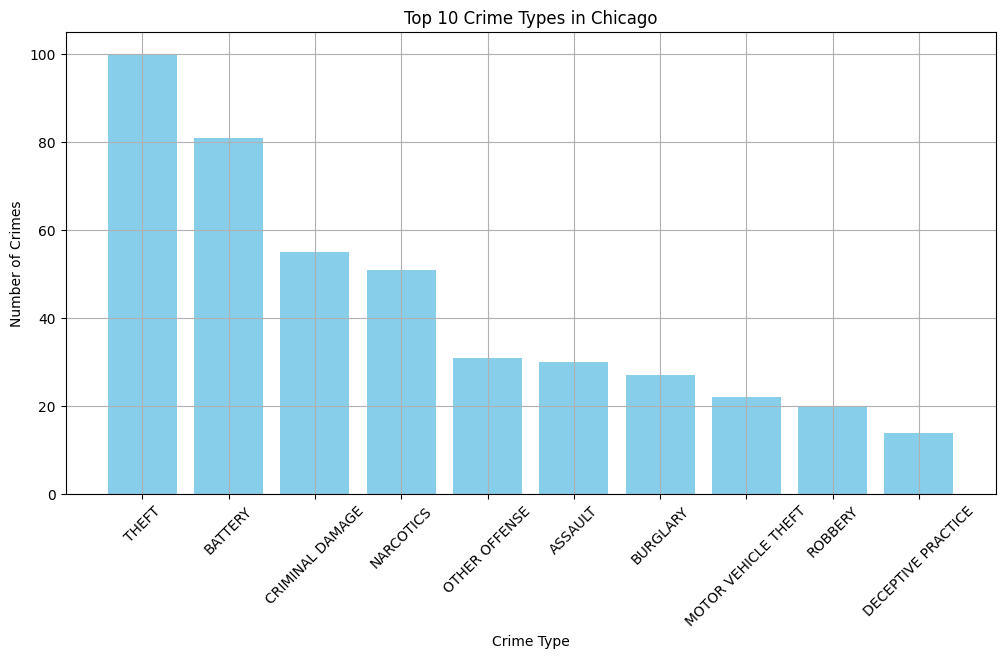

In [36]:
plt.figure(figsize=(12, 6))
plt.bar(crime_type_counts['PRIMARY_TYPE'], crime_type_counts['CrimeCount'], color='skyblue')
plt.title('Top 10 Crime Types in Chicago')
plt.xlabel('Crime Type')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3. Analysis Of Chicago Public School Data

In [37]:
schools_df.head()

,School ID,Name of School,"Elementary, Middle, or High School",Street Address,City,State,ZIP Code,Phone Number,Link,Network Manager,...,RCDTS Code,X_COORDINATE,Y_COORDINATE,Latitude,Longitude,Community Area Number,Community Area Name,Ward,Police District,Location
0,609966,Charles G Hammond Elementary School,ES,2819 W 21st Pl,Chicago,IL,60623,(773) 535-4580,http://schoolreports.cps.edu/SchoolProgressRep...,Pilsen-Little Village Elementary Network,...,150000000000000,1157809.015,1889554.623,41.852691,-87.696278,30,SOUTH LAWNDALE,12,10,"(41.85269133, -87.69627777)"
1,610539,Marvin Camras Elementary School,ES,3000 N Mango Ave,Chicago,IL,60634,(773) 534-2960,http://schoolreports.cps.edu/SchoolProgressRep...,Fullerton Elementary Network,...,150000000000000,1137482.296,1919394.900,41.934966,-87.770165,19,BELMONT CRAGIN,30,25,"(41.93496641, -87.77016525)"
2,609852,Eliza Chappell Elementary School,ES,2135 W Foster Ave,Chicago,IL,60625,(773) 534-2390,http://schoolreports.cps.edu/SchoolProgressRep...,Ravenswood-Ridge Elementary Network,...,150000000000000,1161016.902,1934466.545,41.975867,-87.683254,4,LINCOLN SQUARE,47,20,"(41.975867, -87.68325438)"
3,609835,Daniel R Cameron Elementary School,ES,1234 N Monticello Ave,Chicago,IL,60651,(773) 534-4290,http://schoolreports.cps.edu/SchoolProgressRep...,Garfield-Humboldt Elementary Network,...,150000000000000,1151767.546,1908130.068,41.903785,-87.717963,23,HUMBOLDT PARK,26,25,"(41.90378521, -87.71796315)"
4,610521,Sir Miles Davis Magnet Elementary Academy,ES,6730 S Paulina St,Chicago,IL,60636,(773) 535-9120,http://schoolreports.cps.edu/SchoolProgressRep...,Englewood-Gresham Elementary Network,...,150000000000000,1166133.893,1859929.018,41.771222,-87.666567,67,WEST ENGLEWOOD,15,7,"(41.77122181, -87.66656657)"


In [38]:
schools_df.columns 

Index(['School ID', 'Name of School', 'Elementary, Middle, or High School',
       'Street Address', 'City', 'State', 'ZIP Code', 'Phone Number', 'Link ',
       'Network Manager', 'Collaborative Name',
       'Adequate Yearly Progress Made? ', 'Track Schedule',
       'CPS Performance Policy Status', 'CPS Performance Policy Level',
       'Healthy Schools Certified?', 'Safety Icon ', 'Safety Score',
       'Family Involvement Icon', 'Family Involvement Score',
       'Environment Icon ', 'Environment Score', 'Instruction Icon ',
       'Instruction Score', 'Leaders Icon ', 'Leaders Score ',
       'Teachers Icon ', 'Teachers Score', 'Parent Engagement Icon ',
       'Parent Engagement Score', 'Parent Environment Icon',
       'Parent Environment Score', 'Average Student Attendance',
       'Rate of Misconducts (per 100 students) ', 'Average Teacher Attendance',
       'Individualized Education Program Compliance Rate ', 'Pk-2 Literacy %',
       'Pk-2 Math %', 'Gr3-5 Grade Level Math 

To get an understanding of the distribution of each feauture of the dataset,I created histograms for some of the  variables.

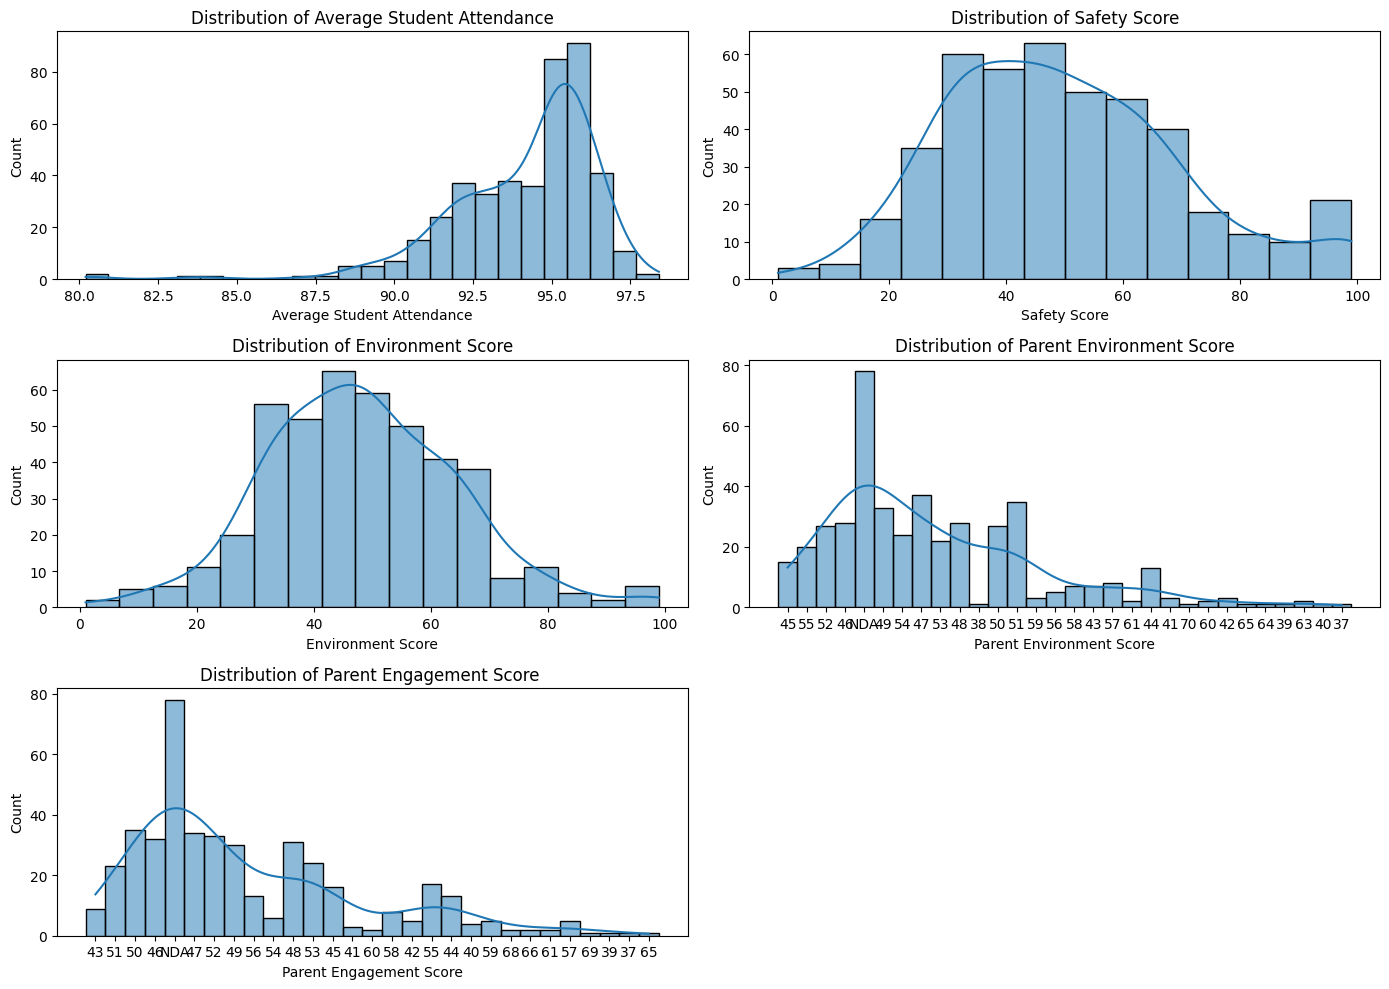

In [39]:
# Creating subplots with only the required number of plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axes = axes.flatten()

# Listing of columns to plot
columns_to_plot = [
    'Average Student Attendance',
    'Safety Score',
    'Environment Score',
    'Parent Environment Score',
    'Parent Engagement Score'
]

# Titles for the plots
titles = [
    'Distribution of Average Student Attendance',
    'Distribution of Safety Score',
    'Distribution of Environment Score',
    'Distribution of Parent Environment Score',
    'Distribution of Parent Engagement Score '
]

# Plotting each column
for i, col in enumerate(columns_to_plot):
    sns.histplot(schools_df[col], kde=True, ax=axes[i])
    axes[i].set_title(titles[i])

# Removing any unused subplots
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<h2>EDA Using SQL Queries<h2>

In [40]:
conn = sqlite3.connect("chicago_data.db")
cur = conn.cursor()
%sql sqlite:///chicago_data.db

1. To find the school(s) with the highest safety score:

In [41]:
%%sql
SELECT "Name of School", "Safety Score"
FROM ChicagoPublicSchools
WHERE "Safety Score" = (
    SELECT MAX("Safety Score")
    FROM ChicagoPublicSchools
);


 * sqlite:///chicago_data.db
Done.


Name of School,Safety Score
Abraham Lincoln Elementary School,99.0
Alexander Graham Bell Elementary School,99.0
Oriole Park Elementary School,99.0
Mary E Courtenay Elementary Language Arts Center,99.0
Ellen Mitchell Elementary School,99.0
Stephen Decatur Classical Elementary School,99.0
James E McDade Elementary Classical School,99.0
Norwood Park Elementary School,99.0
Edgar Allan Poe Elementary Classical School,99.0
Annie Keller Elementary Gifted Magnet School,99.0


2. What are the top 10 schools with the highest "Average Student Attendance"?


In [42]:
%%sql
SELECT "Name of School", "Average Student Attendance"
FROM ChicagoPublicSchools
ORDER BY "Average Student Attendance" DESC
LIMIT 10;


 * sqlite:///chicago_data.db
Done.


Name of School,Average Student Attendance
John Charles Haines Elementary School,98.4
James Ward Elementary School,97.8
Rachel Carson Elementary School,97.6
Edgar Allan Poe Elementary Classical School,97.6
Orozco Fine Arts & Sciences Elementary School,97.6
Annie Keller Elementary Gifted Magnet School,97.5
Lenart Elementary Regional Gifted Center,97.4
Andrew Jackson Elementary Language Academy,97.4
John H Vanderpoel Elementary Magnet School,97.2
Mark Skinner Elementary School,97.1


3. Retrieving the list of 5 Schools with the lowest Average Student Attendance sorted in ascending order based on attendance

In [43]:
%%sql
SELECT "Name of School", "Average Student Attendance"
FROM ChicagoPublicSchools
ORDER BY "Average Student Attendance" ASC
LIMIT 5;


 * sqlite:///chicago_data.db
Done.


Name of School,Average Student Attendance
Near North Elementary School,80.2
Moses Montefiore Special Elementary School,80.4
Kate S Buckingham Special Education Center,83.4
Morgan Park High School,84.2
Oliver Wendell Holmes Elementary School,87.0


4. To acquire the List of 5 schools with lowest safety score.

In [44]:
%%sql
SELECT "Name of School", "Safety Score"
FROM ChicagoPublicSchools
ORDER BY "Safety Score" ASC
LIMIT 5;


 * sqlite:///chicago_data.db
Done.


Name of School,Safety Score
Edmond Burke Elementary School,1.0
Luke O'Toole Elementary School,5.0
George W Tilton Elementary School,6.0
Foster Park Elementary School,11.0
John Fiske Elementary School,13.0


# Analysis Using Sql Views

<h2>View 1: Crime and Census Data by Community Area<h2>

In [45]:
%%sql
CREATE VIEW Crime_census_ AS
SELECT 
    cs.COMMUNITY_AREA_NUMBER,
    cs.COMMUNITY_AREA_NAME,
    COUNT(cr.ID) AS TOTAL_CRIMES,
    cs.PERCENT_OF_HOUSING_CROWDED,
    cs.PERCENT_AGED_16__UNEMPLOYED,
    cs.PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA
FROM 
    ChicagoCrimeData cr
JOIN 
   ChicagoCensusData cs
ON 
    cr.COMMUNITY_AREA_NUMBER = cs.COMMUNITY_AREA_NUMBER
GROUP BY 
    cs.COMMUNITY_AREA_NUMBER, cs.COMMUNITY_AREA_NAME;

 * sqlite:///chicago_data.db
Done.


[]

<h2>View 2: Schools Data with Census Data<h2>

This view combines the schools data with census data to explore education levels.

In [46]:
%%sql
CREATE VIEW Schools_Census_vi AS
SELECT 
    s.School ID,
    s.SCHOOL_NAME,
    s.COMMUNITY_AREA_NUMBER,
    c.COMMUNITY_AREA_NAME,
    s.COLLEGE_ENROLLMENT,
    c.PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA,
    c.PERCENT_AGED_16__UNEMPLOYED
FROM 
   ChicagoPublicSchools s
JOIN 
     ChicagoCensusData c
ON 
    s.COMMUNITY_AREA_NUMBER = c.COMMUNITY_AREA_NUMBER;

 * sqlite:///chicago_data.db
Done.


[]

<h2>EDA On Views<h2>

* Top 5 Community Areas with Most Crimes:

In [47]:
%%sql
SELECT COMMUNITY_AREA_NAME, TOTAL_CRIMES
FROM Crime_census_
ORDER BY TOTAL_CRIMES DESC
LIMIT 5;


 * sqlite:///chicago_data.db
Done.


COMMUNITY_AREA_NAME,TOTAL_CRIMES
Austin,42
Humboldt park,21
Englewood,21
Near West Side,16
North Lawndale,16


* Plotting Crime Distribution by Community Area:

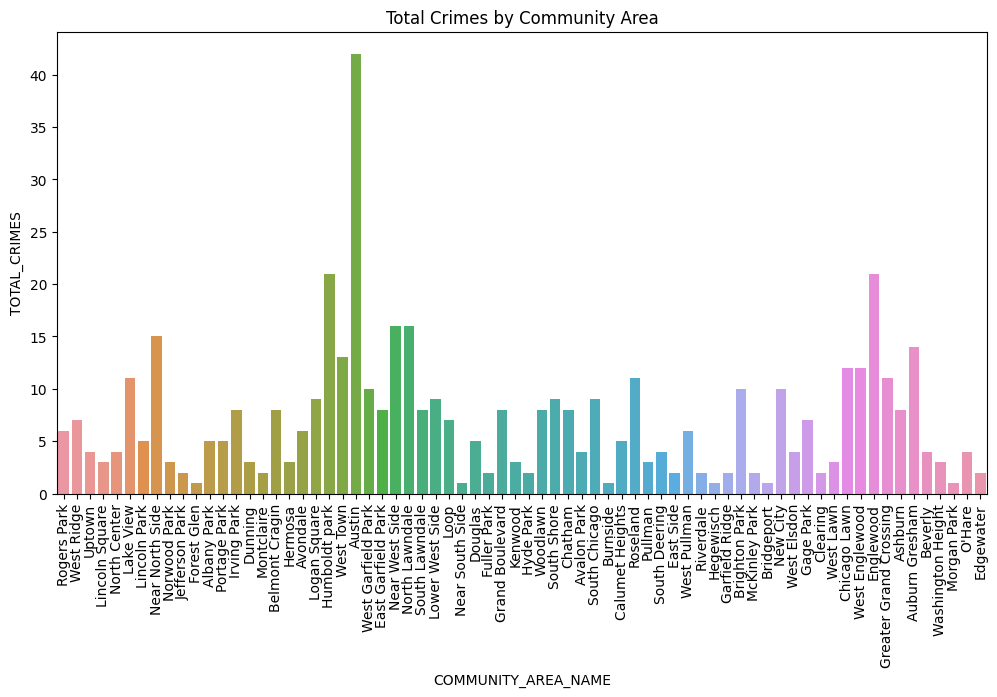

In [48]:
# Loading data from the view into a DataFrame
crime_census_df = pd.read_sql_query('SELECT * FROM Crime_census_', conn)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='COMMUNITY_AREA_NAME', y='TOTAL_CRIMES', data=crime_census_df)
plt.xticks(rotation=90)
plt.title('Total Crimes by Community Area')
plt.show()

**Interpretation of the chart:**

1. Crime Concentration:

* The plot reveals significant variations in crime levels across Chicago's community areas. Some areas have a much higher concentration of crimes compared to others.
* One community area (with the tallest bar) stands out with an exceptionally high number of crimes, suggesting it may be a hotspot for criminal activity. This could be an area of concern for law enforcement and city planners.

2. Areas with Lower Crime Rates:

* Several community areas have relatively low crime rates, as indicated by shorter bars. These areas might be safer or better policed, or they might have demographic or socio-economic characteristics that contribute to lower crime rates.

3. mplications for Resource Allocation:

* The disparities in crime rates across different areas can inform decisions on where to allocate resources. Areas with higher crime rates may need more policing, community programs, or social services to address underlying issues.
* Conversely, areas with lower crime rates might be studied to understand what factors contribute to their safety, and these strategies could potentially be applied to other areas.

4. Urban Planning and Policy:

* Urban planners and policymakers might use this data to develop targeted interventions aimed at reducing crime in the most affected areas. For instance, increased lighting, improved public infrastructure, or community engagement programs could be implemented in high-crime areas.

5. Community Awareness:

* Residents of Chicago could use this information to be more aware of the crime situation in their areas. Community groups might focus efforts on crime prevention and neighborhood watch programs in high-crime areas.

6. Potential for Further Analysis:

* This plot could serve as a starting point for more in-depth analysis. For example, further investigation could explore the types of crimes most prevalent in the high-crime areas, correlations with socio-economic factors, or trends over time.

In summary, the chart highlights the uneven distribution of crime across Chicago's community areas, with some areas being significantly more affected than others. This can help in making informed decisions about where to focus crime reduction efforts and resources.


In [49]:
conn.close()

# Conclusion

The comprehensive analysis of Chicago's data has provided valuable insights into various trends affecting the city. By examining the intersections of crime rates, socio-economic factors, and community characteristics, several key patterns have emerged that offer a deeper understanding of the challenges and opportunities present in Chicago's diverse neighborhoods.

1. Crime Distribution Across Community Areas:
The analysis revealed stark disparities in crime distribution across different community areas. Certain neighborhoods, particularly those with higher poverty rates and lower educational attainment, exhibited significantly higher crime rates. These findings suggest a strong correlation between socio-economic conditions and crime, highlighting the need for targeted interventions in high-crime areas. Such interventions could include increased law enforcement presence, community outreach programs, and economic development initiatives aimed at reducing poverty and improving education.

2. Socio-Economic Disparities:
The socio-economic analysis underscored the wide-ranging disparities that exist within Chicago. Areas with higher median incomes and better access to education and healthcare consistently reported lower crime rates and better overall quality of life. Conversely, communities with lower socio-economic status struggled with higher crime rates, poorer health outcomes, and limited access to quality education. Addressing these disparities is crucial for fostering a more equitable city, and efforts should be directed toward uplifting marginalized communities through policy reforms, improved access to resources, and community-driven development.

3. The Role of Education and Employment:
Education and employment emerged as critical factors influencing the well-being of Chicago’s residents. Higher educational attainment was closely associated with lower crime rates and better economic opportunities. This finding underscores the importance of investing in education, particularly in underserved areas, as a long-term strategy for reducing crime and improving socio-economic outcomes. Expanding job training programs and creating more employment opportunities in disadvantaged areas can also play a pivotal role in addressing some of the underlying causes of crime and poverty.

4. Health and Safety Implications:
The analysis also highlighted the significant impact of socio-economic factors on health and safety. Communities with better access to healthcare services and higher socio-economic status reported fewer health issues and lower crime rates. This correlation suggests that improving access to healthcare, alongside addressing socio-economic disparities, could have a positive ripple effect on the overall safety and well-being of Chicago’s residents.

5. Recommendations for Future Policy and Research:
The findings from this analysis suggest several avenues for future research and policy development. There is a need for more granular data to understand the specific drivers of crime in the most affected areas. Additionally, policymakers should consider multi-faceted approaches that address both the immediate needs of high-crime areas (such as enhanced policing and community engagement) and the long-term socio-economic challenges (such as education and job creation) that contribute to these trends.

In conclusion, while Chicago faces significant challenges, particularly in terms of crime and socio-economic inequality, there are also clear opportunities for positive change. By leveraging data-driven insights and focusing on targeted interventions, the city can work towards reducing crime, improving public safety, and fostering a more equitable and prosperous community for all its residents.

**All Glory Be Given To The Lord Almighty**